# 实验六: 基于集成学习的 Amazon 用户评论质量预测

## 1 案例简介

随着电商平台的兴起，以及疫情的持续影响，线上购物在我们的日常生活中扮演着越来越重要的角色。在进行线上商品挑选时，评论往往是我们十分关注的一个方面。然而目前电商网站的评论质量参差不齐，甚至有水军刷好评或者恶意差评的情况出现，严重影响了顾客的购物体验。因此，对于评论质量的预测成为电商平台越来越关注的话题，如果能自动对评论质量进行评估，就能根据预测结果避免展现低质量的评论。本案例中我们将基于集成学习的方法对 Amazon 现实场景中的评论质量进行预测。

## 2 作业说明

本案例中需要大家完成两种集成学习算法的实现（Bagging、AdaBoost.M1），其中基分类器要求使用 SVM 和决策树两种，因此，一共需要对比四组结果（[AUC](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics) 作为评价指标）：

* Bagging + SVM
* Bagging + 决策树
* AdaBoost.M1 + SVM
* AdaBoost.M1 + 决策树

注意集成学习的核心算法需要**手动进行实现**，基分类器可以调库。

### 2.1 基本要求
* 根据数据格式设计特征的表示
* 汇报不同组合下得到的 AUC
* 结合不同集成学习算法的特点分析结果之间的差异
* （使用 sklearn 等第三方库的集成学习算法会酌情扣分）

### 2.2 扩展要求
* 尝试其他基分类器（如 k-NN、朴素贝叶斯）
* 分析不同特征的影响
* 分析集成学习算法参数的影响

## 3 数据概览

In [1]:
import pandas as pd 
train_df = pd.read_csv('./data/train.csv', sep='\t')
test_df = pd.read_csv('./data/test.csv', sep='\t')
testlabels_df = pd.read_csv('./data/groundTruth.csv')

In [2]:
train_df.head()

,reviewerID,asin,reviewText,overall,votes_up,votes_all,label
0,7885,3901,"First off, allow me to correct a common mistak...",5.0,6,7,0
1,52087,47978,I am really troubled by this Story and Enterta...,3.0,99,134,0
2,5701,3667,A near-perfect film version of a downright glo...,4.0,14,14,1
3,47191,40892,Keep your expectations low. Really really low...,1.0,4,7,0
4,40957,15367,"""they dont make em like this no more...""well.....",5.0,3,6,0


In [3]:
test_df.head()

,Id,reviewerID,asin,reviewText,overall
0,0,82947,37386,I REALLY wanted this series but I am in SHOCK ...,1.0
1,1,10154,23543,I have to say that this is a work of art for m...,4.0
2,2,5789,5724,Alien 3 is certainly the most controversal fil...,3.0
3,3,9198,5909,"I love this film...preachy? Well, of course i...",5.0
4,4,33252,21214,Even though I previously bought the Gamera Dou...,5.0


In [4]:
testlabels_df.head()

,Id,Expected
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


本次数据来源于 Amazon 电商平台，包含超过 50,000 条用户在购买商品后留下的评论，各列的含义如下：

* reviewerID：用户 ID
* asin：商品 ID
* reviewText：英文评论文本
* overall：用户对商品的打分（1-5）
* votes_up：认为评论有用的点赞数（只在训练集出现）
* votes_all：该评论得到的总评价数（只在训练集出现）
* label：评论质量的 label，1 表示高质量，0 表示低质量（只在训练集出现）

评论质量的 label 来自于其他用户对评论的 votes，votes_up/votes_all ≥ 0.9 的作为高质量评论。此外测试集包含一个额外的列 ID，标识了每一个测试的样例。

## 4 特征提取
- 采用`TfidfVectorizer`进行特征提取
- 划分数据集

In [5]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# 创建 TfidfVectorizer 实例，并指定停用词为 'english'
vectorizer = TfidfVectorizer(stop_words='english')

# 训练集
train_X_all = vectorizer.fit_transform(train_df['reviewText'])
train_y_all = np.array(train_df['label'])

# 测试集
test_X_all = vectorizer.transform(test_df['reviewText']) 
test_y_all = np.array(testlabels_df['Expected'])

train_X_all.shape,train_y_all.shape,test_X_all.shape,test_y_all.shape

((57039, 153747), (57039,), (11208, 153747), (11208,))

因为训练集，测试集数据量较大，采用训练集前2000个数据、测试集前200个数据进行代码编写

In [6]:
# 简单训练集
train_X = vectorizer.fit_transform(train_df.reviewText[0:2000])
train_y = np.array(train_df.label[0:2000])

# 简单测试集
test_X = vectorizer.transform(test_df.reviewText[0:200]) 
test_y = np.array(testlabels_df.Expected[0:200])

train_X.shape,train_y.shape,test_X.shape,test_y.shape

((2000, 28961), (2000,), (200, 28961), (200,))

## 5 模型构建
- 采用`sklearn`自带的`BaggingClassifier`, `AdaBoostClassifier`进行训练
- 自己构建 Bagging 算法与 AdaBoost 算法，进行训练

### 5.1 利用sklearn自带库实现集成学习

In [7]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

RANDOM_SEED = 2024

# 定义基分类器
svm_classifier = SVC(C=200,kernel='rbf',probability=True)
tree_classifier = DecisionTreeClassifier()

1. Bagging + SVM

In [8]:
# Bagging + SVM
bagging_svm = BaggingClassifier(estimator=svm_classifier, n_estimators=50, random_state=RANDOM_SEED)
bagging_svm.fit(train_X, train_y)
y_pred_bagging_svm = bagging_svm.predict_proba(test_X)[:, 1]
auc_bagging_svm = roc_auc_score(test_y, y_pred_bagging_svm)
print("Bagging + SVM AUC:", auc_bagging_svm)

Bagging + SVM AUC: 0.747968827723429


2.   Bagging + 决策树

In [9]:
# Bagging + 决策树
bagging_tree = BaggingClassifier(estimator=tree_classifier, n_estimators=50, random_state=RANDOM_SEED)
bagging_tree.fit(train_X, train_y)
y_pred_bagging_tree = bagging_tree.predict_proba(test_X)[:, 1]
auc_bagging_tree = roc_auc_score(test_y, y_pred_bagging_tree)
print("Bagging + Decision Tree AUC:", auc_bagging_tree)

Bagging + Decision Tree AUC: 0.7278229149394795


3. AdaBoost.M1 + SVM

In [10]:
# AdaBoost.M1 + SVM
adaboost_svm = AdaBoostClassifier(estimator=svm_classifier, n_estimators=50, random_state=RANDOM_SEED)
adaboost_svm.fit(train_X, train_y)
y_pred_adaboost_svm = adaboost_svm.predict_proba(test_X)[:, 1]
auc_adaboost_svm = roc_auc_score(test_y, y_pred_adaboost_svm)
print("AdaBoost.M1 + SVM AUC:", auc_adaboost_svm)

AdaBoost.M1 + SVM AUC: 0.7449842480517327


4. AdaBoost.M1 + 决策树

In [11]:
# AdaBoost.M1 + 决策树
adaboost_tree = AdaBoostClassifier(estimator=tree_classifier, n_estimators=50, random_state=RANDOM_SEED)
adaboost_tree.fit(train_X, train_y)
y_pred_adaboost_tree = adaboost_tree.predict_proba(test_X)[:, 1]
auc_adaboost_tree = roc_auc_score(test_y, y_pred_adaboost_tree)
print("AdaBoost.M1 + Decision Tree AUC:", auc_adaboost_tree)

AdaBoost.M1 + Decision Tree AUC: 0.5928535897861051


### 5.2 手动实现集成学习
1. Bagging算法实现

In [27]:
# Bagging 手动实现
def bagging(X, y,test_X, base_classifier,num_classifiers):
    result = np.zeros(test_X.shape[0])  # 记录测试集的预测结果
    for i in range(num_classifiers):
        # 随机采样，有放回
        indices = np.random.choice(len(y), len(y), replace=True)
        X_sampled, y_sampled = X[indices], y[indices]

        print('Model {:<2d} finish!'.format(i))
        # 训练基分类器
        base_classifier.fit(X_sampled, y_sampled)

        # 进行预测
        predict_proba = base_classifier.predict_proba(test_X)[:, 1]
        result += predict_proba  # 累加不同分类器的预测概率
    result /= num_classifiers  # 取平均（投票）
    return result


In [13]:
np.random.seed(RANDOM_SEED)
num_classifiers=10

# 使用 Bagging + SVM
y_pred_bagging_svm_self = bagging(train_X, train_y, test_X, svm_classifier,num_classifiers)
auc_bagging_svm = roc_auc_score(test_y, y_pred_bagging_svm_self)
print("Bagging + SVM AUC:", auc_bagging_svm)

Model 0  finish!
Model 1  finish!
Model 2  finish!
Model 3  finish!
Model 4  finish!
Model 5  finish!
Model 6  finish!
Model 7  finish!
Model 8  finish!
Model 9  finish!
Bagging + SVM AUC: 0.7456474879787763


In [14]:
# 使用 Bagging + 决策树
y_pred_bagging_tree_self = bagging(train_X, train_y, test_X, tree_classifier,num_classifiers)
auc_bagging_tree = roc_auc_score(test_y, y_pred_bagging_tree_self)
print("Bagging + Decision Tree AUC:", auc_bagging_tree)

Model 0  finish!
Model 1  finish!
Model 2  finish!
Model 3  finish!
Model 4  finish!
Model 5  finish!
Model 6  finish!
Model 7  finish!
Model 8  finish!
Model 9  finish!
Bagging + Decision Tree AUC: 0.6983916431769193


2. AdaBoost算法实现

In [15]:
def adaboost(X, y, test_X, base_classifier,num_classifiers):
    result_lst, beta_lst = list(), list()  # 记录每次迭代的预测结果和投票权重
    num_samples = len(y)
    weight = np.ones(num_samples)  # 样本权重，注意总和应为 num_samples

    for i in range(num_classifiers):
        # 使用样本权重训练基分类器
        base_classifier.fit(X, y, sample_weight=weight) 
        print('Model {:<2d} finish!'.format(i))
        
        # 在训练集上进行预测
        train_predict = base_classifier.predict(X) 

        # 计算错误率并更新权重
        error_flag = train_predict != y  # 预测错误的位置
        error = np.sum(weight[error_flag]) / num_samples  # 计算错误率

        if error > 0.5:
            break
        
        # 存储 beta 值和预测结果
        beta = error / (1 - error)
        weight *= (1.0 - error_flag) * beta + error_flag  # 调整权重，正确位置乘上 beta，错误位置还是原来的
        weight /= np.sum(weight) / num_samples  # 归一化，让权重和等于 num_samples

        beta_lst.append(beta)
        predict_proba = base_classifier.predict_proba(test_X)[:, 1]
        result_lst.append(predict_proba)

    # 计算最终预测结果，作为加权和
    beta_lst = np.log(1 / np.array(beta_lst))
    beta_lst /= np.sum(beta_lst)  # 归一化投票权重
    
    result = (np.array(result_lst) * beta_lst[:, None]).sum(0)  # 每一轮的预测结果加权求和
    return result

In [16]:
svm_classifier = SVC(kernel='linear', probability=True)
# 使用 AdaBoost.M1 + SVM
y_pred_adaboost_svm_self = adaboost(train_X, train_y, test_X, svm_classifier,num_classifiers)
auc_adaboost_svm = roc_auc_score(test_y, y_pred_adaboost_svm_self)
print("AdaBoost.M1 + SVM AUC:", auc_adaboost_svm)

Model 0  finish!
Model 1  finish!
Model 2  finish!
Model 3  finish!
Model 4  finish!
Model 5  finish!
Model 6  finish!
Model 7  finish!
Model 8  finish!
Model 9  finish!
AdaBoost.M1 + SVM AUC: 0.7541037970485822


In [17]:
# 使用 AdaBoost.M1 + SVM
tree_classifier=DecisionTreeClassifier(max_depth=10, class_weight='balanced')

y_pred_adaboost_tree_self = adaboost(train_X, train_y, test_X, tree_classifier,num_classifiers)
auc_adaboost_tree = roc_auc_score(test_y, y_pred_adaboost_tree_self)
print("AdaBoost.M1 + Decision Tree AUC:", auc_adaboost_tree)

Model 0  finish!
Model 1  finish!
Model 2  finish!
Model 3  finish!
Model 4  finish!
Model 5  finish!
Model 6  finish!
Model 7  finish!
AdaBoost.M1 + Decision Tree AUC: 0.5791742662908307


### 5.3 绘制ROC曲线
1. 根据sklearn自带的集成学习，绘制的ROC曲线

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 绘制 ROC 曲线
def plot_all_roc_curves(y_true, y_pred_probs, labels):
    plt.figure(figsize=(8, 8))

    for y_pred_prob, label in zip(y_pred_probs, labels):
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(label, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()


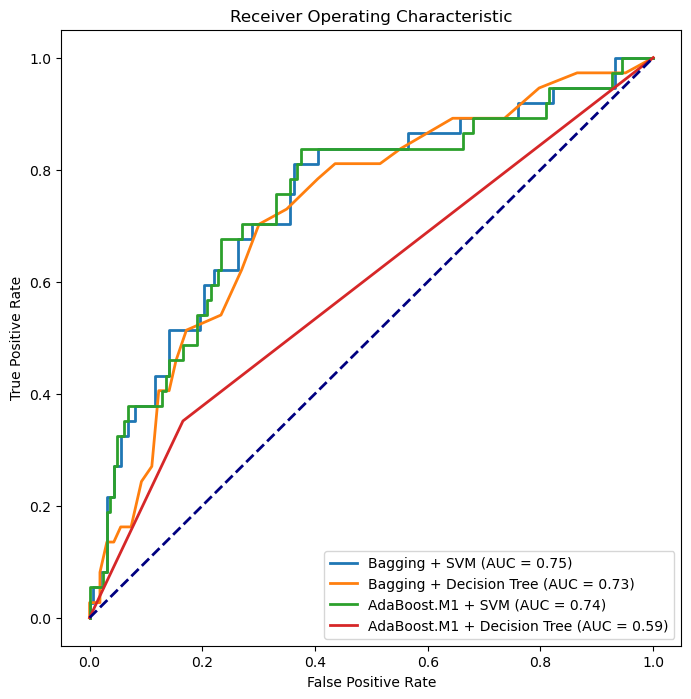

In [19]:
# 绘制所有 ROC 曲线
plot_all_roc_curves(test_y, [y_pred_bagging_svm, y_pred_bagging_tree, y_pred_adaboost_svm, y_pred_adaboost_tree],
                    ['Bagging + SVM', 'Bagging + Decision Tree', 'AdaBoost.M1 + SVM', 'AdaBoost.M1 + Decision Tree'])

2. 根据手动实现的集成学习代码绘制ROC图

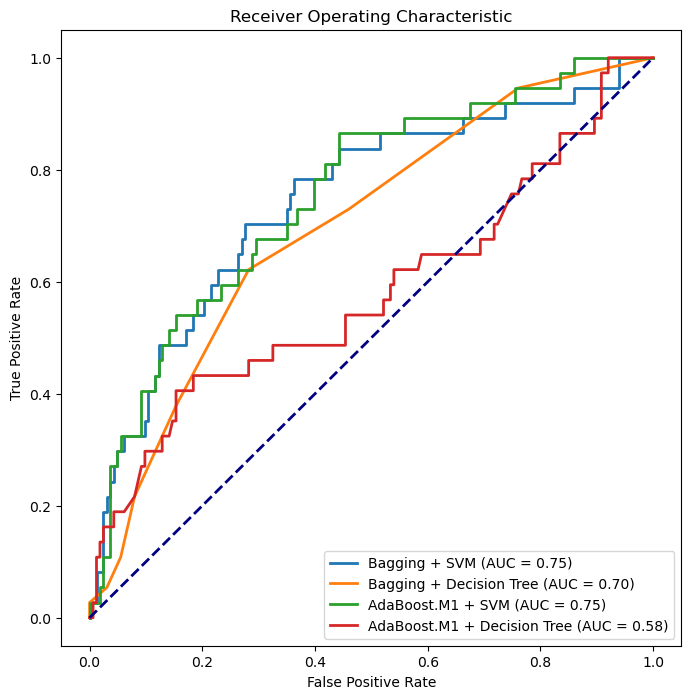

In [20]:
# 绘制所有 ROC 曲线
plot_all_roc_curves(test_y, [y_pred_bagging_svm_self, y_pred_bagging_tree_self, y_pred_adaboost_svm_self, y_pred_adaboost_tree_self],
                    ['Bagging + SVM', 'Bagging + Decision Tree', 'AdaBoost.M1 + SVM', 'AdaBoost.M1 + Decision Tree'])

## 6 云平台提交格式

提交文件需要对测试集中每一条评论给出预测为高质量的概率，每行包括一个 ID（和测试集对应）以及预测的概率 Prediction（0-1的浮点数），用逗号分隔。示例提交格式如下：

```
ID,Prediction
0,0.9
1,0.45
2,0.78
...
```

文件命名没有要求。

In [30]:
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

svm_classifier=svm.LinearSVC(dual='auto')
svm_classifier = CalibratedClassifierCV(svm_classifier, method='sigmoid')
num_classifiers = 100

# 使用 Bagging + SVM
y_pred_bagging_svm_self = bagging(train_X_all, train_y_all, test_X_all, svm_classifier,num_classifiers)
auc_bagging_svm = roc_auc_score(test_y_all, y_pred_bagging_svm_self)
print("Bagging + SVM AUC:", auc_bagging_svm)

Model 0  finish!
Model 1  finish!
Model 2  finish!
Model 3  finish!
Model 4  finish!
Model 5  finish!
Model 6  finish!
Model 7  finish!
Model 8  finish!
Model 9  finish!
Model 10 finish!
Model 11 finish!
Model 12 finish!
Model 13 finish!
Model 14 finish!
Model 15 finish!
Model 16 finish!
Model 17 finish!
Model 18 finish!
Model 19 finish!
Model 20 finish!
Model 21 finish!
Model 22 finish!
Model 23 finish!
Model 24 finish!
Model 25 finish!
Model 26 finish!
Model 27 finish!
Model 28 finish!
Model 29 finish!
Model 30 finish!
Model 31 finish!
Model 32 finish!
Model 33 finish!
Model 34 finish!
Model 35 finish!
Model 36 finish!
Model 37 finish!
Model 38 finish!
Model 39 finish!
Model 40 finish!
Model 41 finish!
Model 42 finish!
Model 43 finish!
Model 44 finish!
Model 45 finish!
Model 46 finish!
Model 47 finish!
Model 48 finish!
Model 49 finish!
Model 50 finish!
Model 51 finish!
Model 52 finish!
Model 53 finish!
Model 54 finish!
Model 55 finish!
Model 56 finish!
Model 57 finish!
Model 58 finis

In [29]:
# 生成提交文件
result_df = pd.DataFrame()
result_df['ID'] = test_df['Id'].values
result_df['Prediction'] = y_pred_bagging_svm_self.round(2)  # 保留两位小数
result_df.to_csv('./result.csv', index=False)